<center><h1>DATA READING</h1></center>

# 1 Downloading the data.

The data is loaded from the Kaggle website. These are pedometer data from a clinical study on anterior cruciate ligament deficiency of the knee. Patients are analyzed while walking and running.


url = "https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwif5pW-oY6DAxW2Q6QEHSVzDY44PBAWegQIBxAB&url=https%3A%2F%2Ffigshare.com%2Farticles%2Fdataset%2FSimilarity_of_Center_of_Pressure_Progression_during_Walking_and_Jogging_of_Anterior_Cruciate_Ligament_Deficient_Patients%2F4537799&usg=AOvVaw3zew23dRMr92Y4PcU6SIOK&opi=89978449"

The data is categorized into two groups: 32 healthy patients and 64 pathological patients.

The objective of this Jupyter notebook is to evaluate plantar pressures using OpenCV algorithms in order to utilize categorical AI models.

In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
class getImage:
    def __init__(self, content, rect):
        self.rect = rect
        self.sequence = []
        for i, line in enumerate(content):
            if 'Frame' in line:
                sub = line.split(' ')
                ind = int(sub[1])
                s = float(sub[2][1:])
                self.sequence.append([i, ind, s])

        self.arrFrame = []
        for i in range(len(self.sequence)-1):
            n0, n1 = self.sequence[i][0], self.sequence[i+1][0]
            cont = content[n0:n1-2]
            img = self.getImage(cont)
            self.arrFrame.append(img)

        curves = self.getCurves()

        # self.arr_images = []
        # for frame in self.arrFrame:
        #     img = self.createImageWithFrame(frame)
        #     h, w = img.shape[:2]
        #     img = cv2.resize(img, (w*5, h*5), interpolation=cv2.INTER_LINEAR)
        #     self.arr_images.append(img)

    def getImage(self, content):
        w, h = self.rect[2], self.rect[3]
        grid = np.zeros((h, w), float)
        for i, line in enumerate(content):
            if len(line) > 0:
                sub = line.split('\t')
                for j, v in enumerate(sub):
                    try:
                        val = float(v)
                        if i < h and j < w:
                            grid[i][j] = val

                    except ValueError:
                        continue
        grid = cv2.flip(grid, 0)
        return grid

    def getCurves(self):
        force, surface = [], []
        self.maxForce = 0
        for seq, img in zip(self.sequence, self.arrFrame):
            val = np.sum(img)
            maxi = np.max(img)
            if self.maxForce < maxi:
                self.maxForce = maxi
            px = cv2.findNonZero(img)
            n = 0
            if px is not None:
                n = len(px)
            speed = seq[-1]
            force.append([speed, val])
            surface.append([speed, n])


        return force, surface

    def createImageWithFrame(self, frame):
        h, w = frame.shape[:2]
        img = np.zeros((h, w, 1), dtype=np.uint8)
        for i in range(h):
            for j in range(w):
                val = frame[i][j]
                if val > 0:
                    val /= self.maxForce
                    g = int(255*val)
                    img[i][j] = g

        return img


In [3]:
class ReadFilePressure:
    def __init__(self, path):
        with open(path) as f:
            content = f.readlines()
        #print('file = {} lines'.format(len(content)))

        self.getSpeed(content)
        self.getRectangle(content)

        self.left = getImage(self.left_content, self.left_rect)
        self.right = getImage(self.rigt_content, self.right_rect)



    def getSpeed(self, content):
        num = -1
        for i, line in enumerate(content):
            if 'Scanning speed' in line:
                num = i
                break

        if num >= 0:
            line = content[num]
            sub = line.split(' ')
            left = float(sub[7])
            right = float(sub[13])
            #print(f'---> scanning speed : left {left} Hz right {right} Hz')


    def getRectangle(self, content):
        left = right = 0
        for i, lines in enumerate(content):
            if len(lines) > 0:
                if 'Left rectangle' in lines:
                    left = i
                if 'Right rectangle' in lines:
                    right = i


        x = int(content[left + 2])
        y = int(content[left + 4])
        w = int(content[left + 6])
        h = int(content[left + 8])
        self.left_rect = [x, y, w, h]

        x = int(content[right + 2])
        y = int(content[right + 4])
        w = int(content[right + 6])
        h = int(content[right + 8])
        self.right_rect = [x, y, w, h]

        self.left_content = content[left:right]
        self.rigt_content = content[right:]


In [4]:
folder = 'partial plantar pressure data sent to PLOS-remove name and data'
healthy =  '02. Part of the 32 healthy volunteers'

patient_healthy = ['01/', '02/', '05/', '07/', '08/', '09/', '10/']
health_data = []
for p in patient_healthy:
    jog, walk = [], []
    title = os.path.join(folder, healthy, 'jog/', p, '*')
    paths = glob.glob(title)
    for path in paths:
        pressure = ReadFilePressure(path)
        jog.append(pressure)

    title = os.path.join(folder, healthy, 'walk/', p, '*')
    paths = glob.glob(title)
    for path in paths:
        pressure = ReadFilePressure(path)
        walk.append(pressure)

    if len(walk) > 0 and len(jog) > 0:
        health_data.append([walk, jog])
    
                    
print(len(health_data), 'patients for health')

7 patients for health


In [5]:
patho = '01. Part of the 64 unilateral ACLD subjects'

patient_patho = ['02/', '04/', '05/', '06/', '07/', '09/']
patho_data = []
for p in patient_patho:
    jog, walk = [], []
    title = os.path.join(folder, patho, 'jog/', p, '*')
    paths = glob.glob(title)
    for path in paths:
        pressure = ReadFilePressure(path)
        jog.append(pressure)

    title = os.path.join(folder, patho, 'walk/', p, '*')
    paths = glob.glob(title)
    for path in paths:
        pressure = ReadFilePressure(path)
        walk.append(pressure)

    if len(walk) > 0 and len(jog) > 0:
        patho_data.append([walk, jog])
    
                    
print(len(patho_data), 'patients for patho')

6 patients for patho


# 2 Foot Analysis

Le dossier contient des donnnées plate forme durant deux gestuelles dynamiques que sont la marche et la course. 

Une plate forme de pression est une matrice de capteurs. Les analyses sont donc des tableaux de matrices de type floatant.

Chaque analyse marche course contient des films, une suite temporelle de matrices.

L'objectif de cette session est de tirer les caractéristiques cliniques de chaque pied.

On utilise alors les algorithmmes fournis par OpenCv et Numpy pour évaluer la forme du pied.

Pour voir le pied dans sa globalité, on calcule l'image moyenne des films de ces deux analyses.

In [6]:
from sklearn.cluster import DBSCAN
from scipy import signal
from scipy.interpolate import griddata
from math import tau

In [7]:

class treatMeanImage:
    def __init__(self, images):
        self.image =  np.mean(images, axis=0).astype(np.uint8)
        self.getStrates()
        self.lissageContours()
        self.getClusters()
        #self.showClusters()
                
    def getStrates(self):
        h, w = self.image.shape[:2]
        max_pressure = np.max(self.image)
        arr_z = np.linspace(0, np.max(self.image), 10)
        self.arrContours, self.arr_z = [], []
        for z in arr_z:
            _, bin  = cv2.threshold(self.image, z, max_pressure, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for contour in contours:
                if len(contour) > 2:
                    self.arrContours.append(contour)
                    self.arr_z.append(z)
        
        
        
    def lissageContours(self):
        for i, cont in enumerate(self.arrContours):
            x = [v[0] for [v] in cont]
            y = [v[1] for [v] in cont]
            x = self.lissCurve(x)
            y = self.lissCurve(y)
            self.arrContours[i] = list(zip(x, y))
            
            


    def getClusters(self):
        h, w = self.image.shape[:2]
        contours, centers = [], []
        for z, contour in zip(self.arr_z, self.arrContours):
            c = self.getCenter(contour)
            centers.append(c)
            cont = []
            for p in contour:
                x, y = p
                cont.append([x, y, z])
            contours.append(cont)
                
        
        lab, nb = self.choiceClusters(centers)

        self.groupes, self.arrCenters = [], []
        for i in range(nb):
            sub_cont, sub_center = [], []
            for j, n in enumerate(lab):
                contour = contours[j]
                c = centers[j]
                if n==i:
                    sub_center.append(c)
                    sub_cont.append(contour)
            self.groupes.append(sub_cont)
            self.arrCenters.append(sub_center)
            
        arrMat = []
        for contours in self.groupes:
            if len(contours) > 1:
                mat = self.getMatPoints(contours)
                arrMat.append(mat)
            if len(contours) == 1:
                contours = self.duplicateContour(contours)
                mat = self.getMatPoints(contours)
                arrMat.append(mat)
                
        self.arrMat = []
        for i in range(20):
            mat = np.zeros((10, 100, 3), float)
            self.arrMat.append(mat)
        
        self.matNorm = []
        for ind, mat in enumerate(arrMat):
            self.arrMat[ind] = mat
            self.matNorm.append(self.normaliseMat(mat))
        
        # for ind, mat in enumerate(self.arrMat):
        #     mat = self.lissageCluster(mat)
        #     self.arrMat[ind] = mat
        
    def normaliseMat(self, mat):
        H, W = self.image.shape[:2]
        Z = np.max(self.image)
        h, w = mat.shape[:2]
        result = np.empty((h, w, 3), float)
        for i in range(h):
            for j in range(w):
                x, y, z = mat[i][j]
                x /= W
                y /= H
                z /= Z
                result[i][j] = [x, y, z]
        return result
                
        

    def duplicateContour(self, contours):
        contour = contours[0]
        x = [v[0] for v in contour]
        y = [v[1] for v in contour]
        vz = contour[0][2]
        z = [vz-2]*len(contour)
        result = []
        result.append(contour)
        result.append(list(zip(x, y, z)))
        return result
        
    def lissageCluster(self, mat):
        h, w = mat.shape[:2]
        grid_x = np.zeros((h, w, 1), float)
        grid_y = np.zeros((h, w, 1), float)
        arr_z = []
        for i in range(h):
            arr_z.append(mat[i][0][2])
            angle = np.linspace(0, tau, w)
            for j in range(w):
                x, y, z = mat[i][j]
                grid_x[i][j] = x
                grid_y[i][j] = y
                
        coef_x = self.calculCoef2D(grid_x, order=20)
        coef_y = self.calculCoef2D(grid_y, order=20)
        
        res_x = self.getImageWithCoef(coef_x)
        res_y = self.getImageWithCoef(coef_y)
        
        result = np.empty((h, w, 3), float)
        for i in range(h):
            x, y, z = [], [], []
            for j in range(w):
                x = res_x[i][j]
                y = res_y[i][j]
                z = arr_z[i]
                result[i][j] = [x, y, z]
        return result
                
            
        
    def showClusters(self):
        colors = ['red', 'green', 'blue', 'brown', 'pink', 'yellow', 'cyan', 'olive']
        fig = plt.figure(figsize=(15, 5))
        ax0 = fig.add_subplot(121)
        ax0.imshow(self.image)

        ax1 = fig.add_subplot(122, projection='3d')

        for vz, contour in zip(self.arr_z, self.arrContours):
            x = [v[0] for v in contour]
            y = [v[1] for v in contour]
            z = [vz]*len(contour)
            #ax1.plot3D(x, y, z, color='black')
            
            
        for i, contours in enumerate(self.groupes):
            color = colors[i]
            for contour in contours:
                x = [v[0] for v in contour]
                y = [v[1] for v in contour]
                z = [v[2] for v in contour]
                ax1.plot3D(x, y, z, color=color)

        
            
        ax1.set_box_aspect(aspect=(1, 2, 1))
        plt.show()

    def drawMat(self, mat, ax, color):
        h, w = mat.shape[:2]
        for i in range(h):
            x, y, z = [], [], []
            for j in range(w):
                p = mat[i][j]
                x.append(p[0])
                y.append(p[1])
                z.append(p[2])
            ax.plot3D(x, y, z, color=color)
            
    def getMatPoints(self, contours):
        arr_x, arr_y, arr_angle, arr_z = [], [], [], []
        for i, contour in enumerate(contours):
            x = [v[0] for v in contour]
            y = [v[1] for v in contour]
            z = [v[2] for v in contour]
            z = contour[0][2]
            vz = [z]*100
            angle = np.linspace(0, 2 * np.pi, len(x))
            xvals = np.linspace(0, 2 * np.pi, 100)
            vx = np.interp(xvals, angle, x)
            vy = np.interp(xvals, angle, y)
            angle = np.linspace(0, tau, 100)
            arr_angle.append(angle)
            arr_x.append(vx)
            arr_z.append(vz)
            arr_y.append(vy)

        res_x, a, z_x = self.getMatInterpol(arr_angle, arr_z, arr_x)
        res_y, a, z_y = self.getMatInterpol(arr_angle, arr_z, arr_y)
        h, w = res_x.shape[0], res_x.shape[1]
        matPoints = np.empty((h, w, 3), float)
        for i in range(h):
            z = z_x[i]
            line = []
            for j in range(w):
                x, y = res_x[i][j], res_y[i][j]
                matPoints[i][j] = [x, y, z]
        return matPoints


    def getCenter(self, cont):
       x = [v[0] for v in cont]
       y = [v[1] for v in cont]
       c = [np.mean(x), np.mean(y)]
       return c

    def choiceClusters(self, arr):
        X = np.array(arr)
        dbscan = DBSCAN(eps=2, min_samples=1)
        cluster_labels = dbscan.fit_predict(X)

        # # Nombre de clusters, en excluant les points considérés comme du bruit
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        #print('clusters =', num_clusters)
        return cluster_labels, num_clusters

    def lissCurve(self, y, order=5):
        #x = range(len(y))
        mid = np.mean(y)
        y -= np.array(mid)
        smoothed = self.cyclic_moving_av(y, n=order )  #1
        return smoothed+np.array(mid)

    def cyclic_moving_av(self, a, n=3, win_type='boxcar'):
        window = signal.get_window(win_type, n, fftbins=False).reshape((1, n))
        shp_a = a.shape
        b = signal.convolve2d(a.reshape((np.prod(shp_a[:-1], dtype=int), shp_a[-1])),
                              window, boundary='wrap', mode='same')
        return (b / np.sum(window)).reshape(shp_a)
    
    def getMatInterpol(self, arr_angle, arr_z, arr):
        A = np.array(arr_angle)
        Z = np.asarray(arr_z)

        arr_x = np.array(arr)
        values = arr_x.flatten()

        minA, maxA = np.min(A), np.max(A)
        minZ, maxZ = np.min(Z), np.max(Z)

        #a = np.arange(minA, maxA, 1.)
        a = np.linspace(minA, maxA, 100)
        z = np.linspace(minZ, maxZ, 10)

        points = np.stack((A.flatten(), Z.flatten()), axis=1)

        res = griddata(points, values, (a[None, :], z[:, None]), method='cubic')

        return res, a, z
    
    def calculCoef2D(self, img, order=5):
        dft_result = cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)

        # Repositionner le composant de fréquence zéro au milieu du spectre
        shift = np.fft.fftshift(dft_result)
        row, col = img.shape[:2]
        center_row, center_col = row // 2, col // 2

        # Créer un masque avec un carré centré de 1s
        mask = np.zeros((row, col, 2), np.uint8)
        bin = np.zeros((row, col, 1), np.uint8)
        p0 = [40, 0]
        p1 = [20, 10]
        p3 = [60, 0]
        p2 = [80, 10]
        line = np.array([p0, p1, p2, p3])
        cv2.polylines(bin, [line], True, (255), 1)
        #plt.imshow(bin)
        #plt.show()
        rad = order
        mask[center_row - rad:center_row + rad, center_col - rad:center_col + rad] = 1

        # Appliquer le masque à la DFT
        fft_shift = shift * mask
        mag = cv2.magnitude(shift[:, :, 0], shift[:, :, 1])
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        h, w = mag.shape[:2]
        for i in range(h):
            x, y, z = [], [], []
            
        plt.show()
        return fft_shift
    
    def getImageWithCoef(self, coef):
        fft_ifft_shift = np.fft.ifftshift(coef)
        result = cv2.idft(fft_ifft_shift, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
        return result



In [8]:
mean_health = []
for i, p in enumerate(health_data):
    print('healthy patient', i, len(p))
    walk, jog = p
    w, j = [], []
    for pressure in walk:
        left, right = pressure.left, pressure.right
        mean_left = treatMeanImage(left.arrFrame)
        mean_right = treatMeanImage(right.arrFrame)
        w.append([mean_left, mean_right])
    for pressure in jog:
        left, right = pressure.left, pressure.right
        mean_left = treatMeanImage(left.arrFrame)
        mean_right = treatMeanImage(right.arrFrame)
        j.append([mean_left, mean_right])
    mean_health.append([w, j])

mean_patho = []
for i, p in enumerate(patho_data):
    print('patho patient', i, len(p))
    walk, jog = p
    w, j = [], []
    for pressure in walk:
        left, right = pressure.left, pressure.right
        mean_left = treatMeanImage(left.arrFrame)
        mean_right = treatMeanImage(right.arrFrame)
        w.append([mean_left, mean_right])
    for pressure in jog:
        left, right = pressure.left, pressure.right
        mean_left = treatMeanImage(left.arrFrame)
        mean_right = treatMeanImage(right.arrFrame)
        j.append([mean_left, mean_right])
    mean_patho.append([w, j])
    
        
        

healthy patient 0 2
healthy patient 1 2
healthy patient 2 2
healthy patient 3 2
healthy patient 4 2
healthy patient 5 2
healthy patient 6 2
patho patient 0 2
patho patient 1 2
patho patient 2 2
patho patient 3 2
patho patient 4 2
patho patient 5 2


Démonstration du code sur une image

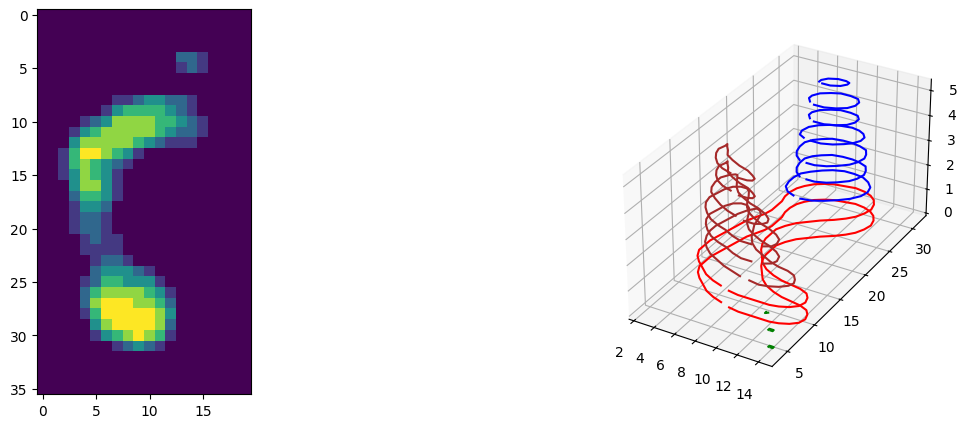

In [9]:
mean_left = mean_health[0][0][0][0]
mean_left.showClusters()


Maintenant chaque segment du pied est une matrice de 10 contours de 100 points 3D (10, 100, 3) et les courbes sont lissées. Chaque pied contient 20 segments.

# 3 Deep Learning

In [10]:
def resize_image(image, desired_height=30, desired_width=30):
    # Obtenir les dimensions de l'image d'entrée
    height, width = image.shape[:2]
    
    # Calculer les quantités de bordures nécessaires pour atteindre la taille désirée
    top_border = max(0, (desired_height - height) // 2)
    bottom_border = max(0, desired_height - height - top_border)
    left_border = max(0, (desired_width - width) // 2)
    right_border = max(0, desired_width - width - left_border)
    
    # Ajouter des bordures à l'image pour atteindre la taille désirée
    resized_image = cv2.copyMakeBorder(image, top_border, bottom_border, left_border, right_border, cv2.BORDER_CONSTANT, value=0)
    
    # Redimensionner l'image à la taille finale désirée
    resized_image = cv2.resize(resized_image, (desired_width, desired_height))
    resized_image = resized_image.astype(np.float32) / 255.0
    return resized_image

In [11]:
X, y_name, y_patho, y_lat, y_gait = [], [], [], [], []

for i, p in enumerate(mean_health):
    walk, jog = p
    print('patient', i)
    for left, _ in walk:
        X.append(left.image)
        y_name.append(i)  # Utilisation de l'index du patient comme label
        y_lat.append(0)
        y_gait.append(0)
        y_patho.append(0)
    for _, right in walk:
        X.append(right.image)
        y_name.append(i)  # Utilisation de l'index du patient comme label
        y_lat.append(1)
        y_gait.append(0)
        y_patho.append(0)

            
    for left, _ in jog:
        X.append(left.image)
        y_name.append(i)  # Utilisation de l'index du patient comme label
        y_lat.append(0)
        y_gait.append(1)
        y_patho.append(0)
        
    for _, right in jog:
        X.append(right.image)
        y_name.append(i)  # Utilisation de l'index du patient comme label
        y_lat.append(1)
        y_gait.append(1)
        y_patho.append(0)

for i, p in enumerate(mean_patho):
    walk, jog = p
    print('patient', i)
    for left, _ in walk:
        X.append(left.image)
        y_name.append(i)  # Utilisation de l'index du patient comme label
        y_lat.append(0)
        y_gait.append(0)
        y_patho.append(1)
    for _, right in walk:
        X.append(right.image)
        y_name.append(i)  # Utilisation de l'index du patient comme label
        y_lat.append(1)
        y_gait.append(0)
        y_patho.append(1)

            
    for left, _ in jog:
        X.append(left.image)
        y_name.append(i)  # Utilisation de l'index du patient comme label
        y_lat.append(0)
        y_gait.append(1)
        y_patho.append(1)
        
    for _, right in jog:
        X.append(right.image)
        y_name.append(i)  # Utilisation de l'index du patient comme label
        y_lat.append(1)
        y_gait.append(1)
        y_patho.append(1)

print('Données images :', len(X))
print('Labels :', len(y_name), len(y_gait), len(y_lat), len(y_patho))


patient 0
patient 1
patient 2
patient 3
patient 4
patient 5
patient 6
patient 0
patient 1
patient 2
patient 3
patient 4
patient 5
Données images : 266
Labels : 266 266 266 266


In [12]:
def resize_image(image, desired_size):
    old_size = image.shape[:2]
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    color = [0, 0, 0]  # Couleur des bords ajoutés
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_image.astype(float)

arr_img = X.copy()
X = []
for img in arr_img:
    img = resize_image(img, 40)
    img /= 255.
    X.append(img)
    


In [13]:
from sklearn.model_selection import train_test_split

X = np.array(X)
y = np.array(y_patho).astype(float)
print('data', len(X), len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


data 266 266


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Création du modèle séquentiel
model = models.Sequential()

# Ajout de la couche de convolution
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 1)))  # Entrée de taille 40x40 avec 3 canaux de couleur

# Ajout d'une couche de mise en commun (pooling)
model.add(layers.MaxPooling2D((2, 2)))

# Aplatir les données pour les passer à travers une couche dense
model.add(layers.Flatten())

# Ajout d'une couche dense avec une sortie catégorielle
model.add(layers.Dense(1, activation='sigmoid'))  # Exemple avec 2 classes catégorielles

# Compilation du modèle
model.compile(optimizer='adam', loss='cross_crossentropy', metrics=['accuracy'])

# Affichage de la structure du modèle
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 38, 38, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 11552)             0         


                                                                 
 dense_2 (Dense)             (None, 1)                 11553     
                                                                 
Total params: 11873 (46.38 KB)
Trainable params: 11873 (46.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
from tensorflow.keras import optimizers
from keras.optimizers import Adam



# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


ValueError: in user code:

    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 252, in __call__
        self.build(y_pred)
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 194, in build
        self._losses = tf.nest.map_structure(
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 365, in _get_loss_object
        loss = losses_mod.get(loss)
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/losses.py", line 2965, in get
        return deserialize(identifier, use_legacy_format=use_legacy_format)
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/losses.py", line 2912, in deserialize
        return legacy_serialization.deserialize_keras_object(
    File "/Users/georgesschmidt/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/saving/legacy/serialization.py", line 537, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: 'cross_crossentropy'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


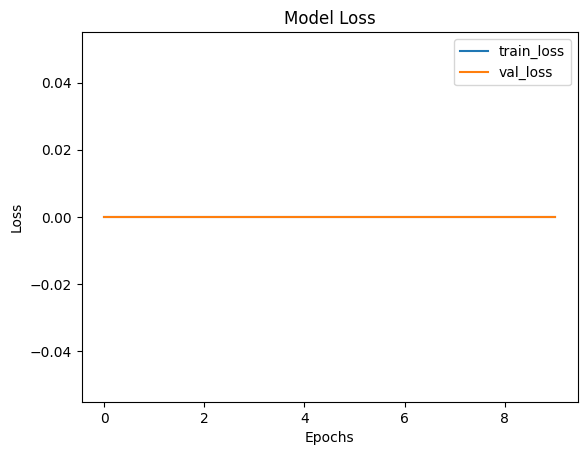

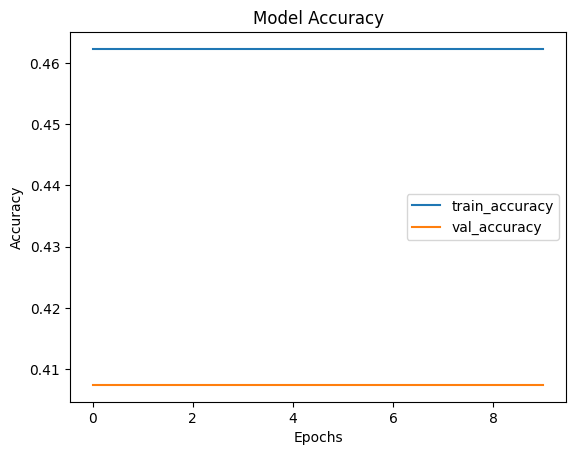

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()